# Logit-Normal Distribution with NGBoost

**Problem**: Regression on bounded (0, 1) outcomes where the latent process
is approximately Gaussian after a logit transform.

**When to use**:
- Bioassay dose-response modeling: proportion responding at each dose level
- Compositional data: proportions that arise from logistic-normal mixtures
- Species prevalence: probability of species presence across habitats
- Any (0,1)-valued outcome where Beta's shape family is too restrictive

**How it differs from Beta**: The Logit-Normal assumes logit(Y) ~ Normal,
giving different tail behavior. It can be more natural when the generative
process involves a logistic transform of latent features.

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import LogitNormal

## 1. Generate synthetic data in (0, 1)

In [3]:
np.random.seed(42)
n_samples = 1000
n_features = 5

X = np.random.randn(n_samples, n_features)

# True mu depends on features, sigma is constant
true_mu = 0.5 * X[:, 0] - 0.3 * X[:, 1]
true_sigma = 0.8
z = np.random.normal(true_mu, true_sigma)
Y = 1 / (1 + np.exp(-z))
Y = np.clip(Y, 1e-4, 1 - 1e-4)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.4f}, {Y.max():.4f}]")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0.0583, 0.9675]
Train: 800, Test: 200


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=6,
    splitter="best",
    random_state=None,
)

ngb = NGBRegressor(
    Dist=LogitNormal,
    Base=tree_learner,
    n_estimators=1000,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
Y_pred = ngb.predict(X_test)
dists = ngb.pred_dist(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  mu:    {dists.mu[:5].round(3)}")
print(f"  sigma: {dists.sigma[:5].round(3)}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(4)}")
print(f"Actual (first 5):          {Y_test[:5].round(4)}")

Estimated parameters (first 5 test samples):
  mu:    [-0.502 -1.087  0.062  0.521 -0.347]
  sigma: [0.178 0.256 0.245 0.283 0.255]

Predicted mean (first 5): [0.3777 0.2552 0.5178 0.6255 0.412 ]
Actual (first 5):          [0.3917 0.4897 0.5909 0.6003 0.335 ]


## 4. Sampling and quantiles

Quantiles can be estimated from samples (no closed-form CDF for LogitNormal).

In [6]:
# Sample from first test distribution
samples_0 = dists[0].sample(5000)
print(f"Samples from predicted dist for test sample 0:")
print(f"  mean:   {np.mean(samples_0):.4f}")
print(f"  actual: {Y_test[0]:.4f}")

# Estimate quantiles from samples
q10 = np.percentile(samples_0, 10)
q50 = np.percentile(samples_0, 50)
q90 = np.percentile(samples_0, 90)
print(f"\nEstimated quantiles: 10th={q10:.4f}, 50th={q50:.4f}, 90th={q90:.4f}")

Samples from predicted dist for test sample 0:
  mean:   0.3778
  actual: 0.3917

Estimated quantiles: 10th=0.3254, 50th=0.3777, 90th=0.4311


## 5. Visualize

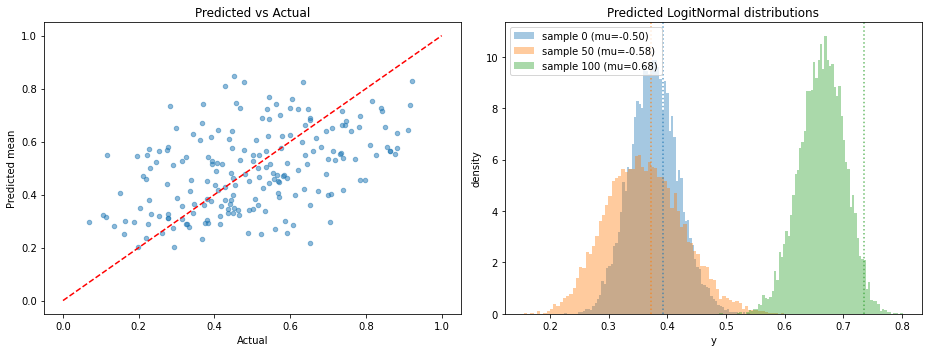

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: predictions vs actuals
ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

# Right: predicted LogitNormal densities for 3 test samples (via histogram of samples)
ax = axes[1]
for idx in [0, 50, 100]:
    s = dists[idx].sample(10000)
    ax.hist(s, bins=80, density=True, alpha=0.4,
            label=f"sample {idx} (mu={dists.mu[idx]:.2f})")
    ax.axvline(Y_test[idx], color=f"C{[0,50,100].index(idx)}",
               linestyle=":", alpha=0.7)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted LogitNormal distributions")
ax.legend()

plt.tight_layout()
plt.show()